In [1]:
# MIT image
# Made by : HERO Kwon
# Date : 190108

import os
import numpy as np
import pandas as pd
import pickle
import gzip
import matplotlib.pyplot as plt
import math
import cmath

# data path
#path_meta = '/home/herokwon/mount_data/Data/Wi-Fi_meta/'
#path_csi = '/home/herokwon/mount_data/Data/Wi-Fi_processed/'
#path_csi_np = '/home/herokwon/mount_data/Data/Wi-Fi_processed_npy/'

# data path_mi
path_csi = 'D:\\Data\\Wi-Fi_processed\\'
path_csi_np = 'D:\\Data\\Wi-Fi_processed_npy\\'
path_meta = 'D:\\Data\\Wi-Fi_meta\\'
path_sc = 'D:\\Data\\Wi-Fi_info\\'
path_mit_image = 'D:\\Data\\Wi-Fi_mit_image\\'

In [2]:
# data info
df_info = pd.read_csv(path_meta+'data_subc_sig_v1.csv')
df_info = df_info[df_info.id_location==1]

#df.info = df.info.iloc[0:250]
#df.info = df.info.iloc[250:500]
#df.info = df.info.iloc[500:750]
#df.info = df.info.iloc[750:1000]
#df.info = df.info.iloc[1000:1250]
#df.info = df.info.iloc[1250:1500]
#df.info = df.info.iloc[1500:1750]
#df.info = df.info.iloc[1750:2000]
#df.info = df.info.iloc[2000:2250]
#df.info = df.info.iloc[2250:2500]
#df.info = df.info.iloc[2500:2750]
#df.info = df.info.iloc[2750:3000]
#df.info = df.info.iloc[3000:3250]
#df.info = df.info.iloc[3250:3500]
#df.info = df.info.iloc[3500:3632]


person_uid = np.unique(df_info['id_person'])
dict_id = dict(zip(person_uid,np.arange(len(person_uid))))
csi_time = 100 #int(np.max(df_info['len']))
# parameters
max_value = np.max(df_info['max'].values)
#no_classes = len(np.unique(df_info['id_person']))
no_classes = len(dict_id)
csi_subc = 30
input_shape = (csi_time, csi_subc, 6)

# freq BW list
bw_list = pd.read_csv(path_meta+'wifi_f_bw_list.csv')

# avg Array
with open(path_meta + 'dict_avgcsi.pickle','rb') as f:
    dict_avg = pickle.load(f)

In [3]:
# make data generator
def gen_csi(df_info,dict_avg,id_num,len_num):
    for file in np.unique(df_info.id.values):
        
        # Label
        id_key = df_info[df_info.id==file][['id_person','id_location','id_direction','id_exp']].values[0].astype('int')
        data1_y = dict_id[id_key[0]]
        
        # read sample data
        # load and uncompress.
        with gzip.open(path_csi+file+'.pickle.gz','rb') as f:
            data1 = pickle.load(f)
            
        # subtract avg
        read_avg = dict_avg[id_key[0]][0]
        nonzero_avg = read_avg[np.nonzero(read_avg)].reshape([-1,30,2,3])
        arr_avg = np.mean(nonzero_avg,axis=0)
        data1_diff = data1 - arr_avg #np.diff(data1,axis=0)

        s_idx = (np.arange(len_num) * data1_diff.shape[0] / len_num).astype('int')
        data1_s = data1_diff[s_idx]
        # zero pad
        #pad_len = len_num - data1_diff.shape[0]
        #data1_pad = np.pad(data1_diff,((0,pad_len),(0,0),(0,0),(0,0)),'constant',constant_values=0)

        # subcarrier info
        #data1_sc_df = pd.read_csv(path_sc + file + '_df_sc.csv')
        #data1_time = np.diff(data1_sc_df['timestamp_low'])
        #data1_time_pad = np.pad(data1_time,((1,pad_len)),'constant',constant_values=0)
        
        
        yield(data1_s ,data1_y,id_key)#,data1_time_pad)


gen = gen_csi(df_info,dict_avg,no_classes,csi_time)


In [4]:
# 3D scan
m,n = 2,3
c =  299792458 # speed of light 
#r = (160 + 160 + 164) * 0.01 # meter
r = 1.64 #meter
d = 45 * 0.01 # meter
ch = 8#3
max_subc = 30

In [5]:
from numba import vectorize
@vectorize(['complex64(complex64,float32,float32,int32,int32,float32,float32,float32,int32)'], target='cpu')
def Recon3d(sig,theta,sigma,m,n,lam,d,r,c):
    #above_eq1 = 1j * (2*math.pi) * k * r * t / c
    #above_eq1 = 1j * (2*math.pi) * c * dt * 0.000001 / lam
    above_eq1 = 1j * (2*math.pi) * r / lam
    above_eq2 = 1j * (2*math.pi/lam) * math.sin(theta) * ((n+1)*d*math.cos(sigma) + (m+1)*d*math.sin(sigma))
    eq_res = sig* cmath.exp(above_eq1) * cmath.exp(above_eq2)
    #eq_res = cmath.exp(above_eq1) * cmath.exp(above_eq2)
    return eq_res #math.atan2(eq_res.imag,eq_res.real)

In [6]:
def Calc3d(target_sig,max_subc,theta,sigma,bw_list,ch,d,r,c,m,n):
    #vectorize arrays
    subc_array = np.ones([csi_time,max_subc,m,n])
    m_array = np.ones([csi_time,max_subc,m,n])
    n_array = np.ones([csi_time,max_subc,m,n])
    for i in range(max_subc):
        subc_array[:,i,:,:] = i
    for i in range(m):
        m_array[:,:,i,:] = i
    for i in range(n):
        n_array[:,:,:,i] = i
    subc_array = subc_array.flatten().astype(np.int32)
    m_array = m_array.flatten().astype(np.int32)
    n_array = n_array.flatten().astype(np.int32)
    lam_array = np.array([c*0.000001/bw_list[str(e)][ch] for e in subc_array],dtype=np.float32)
    
    target_array = target_sig.flatten().astype(np.complex64)
    
    #3d recon
    sum_eq = np.zeros(csi_time*max_subc*m*n*th_range,dtype=np.complex_)
    sum_eq = Recon3d(target_array,theta,sigma,m_array,n_array,lam_array,d,r,c)

    sum_reshape = np.sum(sum_eq.reshape([-1,max_subc,m,n]),axis=(1,2,3))
    return(np.abs(sum_reshape))


In [7]:
th_range,si_range = (30,30)
sig_mat = np.zeros([csi_time,2*th_range,2*si_range])

import time
t1 = time.time()

for idx_th,i in enumerate(range(-th_range,th_range)):
    for idx_si,j in enumerate(range(-si_range,si_range)):
        theta = i * (np.radians(60)/2) / th_range
        sigma = j * (np.radians(60)/2) / si_range
        sig_mat[:,idx_th,idx_si] = Calc3d(target_sig,max_subc,theta,sigma,bw_list,ch,d,r,c,m,n)

        print((i,j))
        
print(time.time()-t1)


(-30, -30)
(-30, -29)
(-30, -28)
(-30, -27)
(-30, -26)
(-30, -25)
(-30, -24)
(-30, -23)
(-30, -22)
(-30, -21)
(-30, -20)
(-30, -19)
(-30, -18)
(-30, -17)
(-30, -16)
(-30, -15)
(-30, -14)
(-30, -13)
(-30, -12)
(-30, -11)
(-30, -10)
(-30, -9)
(-30, -8)
(-30, -7)
(-30, -6)
(-30, -5)
(-30, -4)
(-30, -3)
(-30, -2)
(-30, -1)
(-30, 0)
(-30, 1)
(-30, 2)
(-30, 3)
(-30, 4)
(-30, 5)
(-30, 6)
(-30, 7)
(-30, 8)
(-30, 9)
(-30, 10)
(-30, 11)
(-30, 12)
(-30, 13)
(-30, 14)
(-30, 15)
(-30, 16)
(-30, 17)
(-30, 18)
(-30, 19)
(-30, 20)
(-30, 21)
(-30, 22)
(-30, 23)
(-30, 24)
(-30, 25)
(-30, 26)
(-30, 27)
(-30, 28)
(-30, 29)
(-29, -30)
(-29, -29)
(-29, -28)
(-29, -27)
(-29, -26)
(-29, -25)
(-29, -24)
(-29, -23)
(-29, -22)
(-29, -21)
(-29, -20)
(-29, -19)
(-29, -18)
(-29, -17)
(-29, -16)
(-29, -15)
(-29, -14)
(-29, -13)
(-29, -12)
(-29, -11)
(-29, -10)
(-29, -9)
(-29, -8)
(-29, -7)
(-29, -6)
(-29, -5)
(-29, -4)
(-29, -3)
(-29, -2)
(-29, -1)
(-29, 0)
(-29, 1)
(-29, 2)
(-29, 3)
(-29, 4)
(-29, 5)
(-29, 6)
(-29,

(-17, -6)
(-17, -5)
(-17, -4)
(-17, -3)
(-17, -2)
(-17, -1)
(-17, 0)
(-17, 1)
(-17, 2)
(-17, 3)
(-17, 4)
(-17, 5)
(-17, 6)
(-17, 7)
(-17, 8)
(-17, 9)
(-17, 10)
(-17, 11)
(-17, 12)
(-17, 13)
(-17, 14)
(-17, 15)
(-17, 16)
(-17, 17)
(-17, 18)
(-17, 19)
(-17, 20)
(-17, 21)
(-17, 22)
(-17, 23)
(-17, 24)
(-17, 25)
(-17, 26)
(-17, 27)
(-17, 28)
(-17, 29)
(-16, -30)
(-16, -29)
(-16, -28)
(-16, -27)
(-16, -26)
(-16, -25)
(-16, -24)
(-16, -23)
(-16, -22)
(-16, -21)
(-16, -20)
(-16, -19)
(-16, -18)
(-16, -17)
(-16, -16)
(-16, -15)
(-16, -14)
(-16, -13)
(-16, -12)
(-16, -11)
(-16, -10)
(-16, -9)
(-16, -8)
(-16, -7)
(-16, -6)
(-16, -5)
(-16, -4)
(-16, -3)
(-16, -2)
(-16, -1)
(-16, 0)
(-16, 1)
(-16, 2)
(-16, 3)
(-16, 4)
(-16, 5)
(-16, 6)
(-16, 7)
(-16, 8)
(-16, 9)
(-16, 10)
(-16, 11)
(-16, 12)
(-16, 13)
(-16, 14)
(-16, 15)
(-16, 16)
(-16, 17)
(-16, 18)
(-16, 19)
(-16, 20)
(-16, 21)
(-16, 22)
(-16, 23)
(-16, 24)
(-16, 25)
(-16, 26)
(-16, 27)
(-16, 28)
(-16, 29)
(-15, -30)
(-15, -29)
(-15, -28)
(-15, 

(-3, -2)
(-3, -1)
(-3, 0)
(-3, 1)
(-3, 2)
(-3, 3)
(-3, 4)
(-3, 5)
(-3, 6)
(-3, 7)
(-3, 8)
(-3, 9)
(-3, 10)
(-3, 11)
(-3, 12)
(-3, 13)
(-3, 14)
(-3, 15)
(-3, 16)
(-3, 17)
(-3, 18)
(-3, 19)
(-3, 20)
(-3, 21)
(-3, 22)
(-3, 23)
(-3, 24)
(-3, 25)
(-3, 26)
(-3, 27)
(-3, 28)
(-3, 29)
(-2, -30)
(-2, -29)
(-2, -28)
(-2, -27)
(-2, -26)
(-2, -25)
(-2, -24)
(-2, -23)
(-2, -22)
(-2, -21)
(-2, -20)
(-2, -19)
(-2, -18)
(-2, -17)
(-2, -16)
(-2, -15)
(-2, -14)
(-2, -13)
(-2, -12)
(-2, -11)
(-2, -10)
(-2, -9)
(-2, -8)
(-2, -7)
(-2, -6)
(-2, -5)
(-2, -4)
(-2, -3)
(-2, -2)
(-2, -1)
(-2, 0)
(-2, 1)
(-2, 2)
(-2, 3)
(-2, 4)
(-2, 5)
(-2, 6)
(-2, 7)
(-2, 8)
(-2, 9)
(-2, 10)
(-2, 11)
(-2, 12)
(-2, 13)
(-2, 14)
(-2, 15)
(-2, 16)
(-2, 17)
(-2, 18)
(-2, 19)
(-2, 20)
(-2, 21)
(-2, 22)
(-2, 23)
(-2, 24)
(-2, 25)
(-2, 26)
(-2, 27)
(-2, 28)
(-2, 29)
(-1, -30)
(-1, -29)
(-1, -28)
(-1, -27)
(-1, -26)
(-1, -25)
(-1, -24)
(-1, -23)
(-1, -22)
(-1, -21)
(-1, -20)
(-1, -19)
(-1, -18)
(-1, -17)
(-1, -16)
(-1, -15)
(-1, -14)
(

(13, -4)
(13, -3)
(13, -2)
(13, -1)
(13, 0)
(13, 1)
(13, 2)
(13, 3)
(13, 4)
(13, 5)
(13, 6)
(13, 7)
(13, 8)
(13, 9)
(13, 10)
(13, 11)
(13, 12)
(13, 13)
(13, 14)
(13, 15)
(13, 16)
(13, 17)
(13, 18)
(13, 19)
(13, 20)
(13, 21)
(13, 22)
(13, 23)
(13, 24)
(13, 25)
(13, 26)
(13, 27)
(13, 28)
(13, 29)
(14, -30)
(14, -29)
(14, -28)
(14, -27)
(14, -26)
(14, -25)
(14, -24)
(14, -23)
(14, -22)
(14, -21)
(14, -20)
(14, -19)
(14, -18)
(14, -17)
(14, -16)
(14, -15)
(14, -14)
(14, -13)
(14, -12)
(14, -11)
(14, -10)
(14, -9)
(14, -8)
(14, -7)
(14, -6)
(14, -5)
(14, -4)
(14, -3)
(14, -2)
(14, -1)
(14, 0)
(14, 1)
(14, 2)
(14, 3)
(14, 4)
(14, 5)
(14, 6)
(14, 7)
(14, 8)
(14, 9)
(14, 10)
(14, 11)
(14, 12)
(14, 13)
(14, 14)
(14, 15)
(14, 16)
(14, 17)
(14, 18)
(14, 19)
(14, 20)
(14, 21)
(14, 22)
(14, 23)
(14, 24)
(14, 25)
(14, 26)
(14, 27)
(14, 28)
(14, 29)
(15, -30)
(15, -29)
(15, -28)
(15, -27)
(15, -26)
(15, -25)
(15, -24)
(15, -23)
(15, -22)
(15, -21)
(15, -20)
(15, -19)
(15, -18)
(15, -17)
(15, -16)
(15

(28, -11)
(28, -10)
(28, -9)
(28, -8)
(28, -7)
(28, -6)
(28, -5)
(28, -4)
(28, -3)
(28, -2)
(28, -1)
(28, 0)
(28, 1)
(28, 2)
(28, 3)
(28, 4)
(28, 5)
(28, 6)
(28, 7)
(28, 8)
(28, 9)
(28, 10)
(28, 11)
(28, 12)
(28, 13)
(28, 14)
(28, 15)
(28, 16)
(28, 17)
(28, 18)
(28, 19)
(28, 20)
(28, 21)
(28, 22)
(28, 23)
(28, 24)
(28, 25)
(28, 26)
(28, 27)
(28, 28)
(28, 29)
(29, -30)
(29, -29)
(29, -28)
(29, -27)
(29, -26)
(29, -25)
(29, -24)
(29, -23)
(29, -22)
(29, -21)
(29, -20)
(29, -19)
(29, -18)
(29, -17)
(29, -16)
(29, -15)
(29, -14)
(29, -13)
(29, -12)
(29, -11)
(29, -10)
(29, -9)
(29, -8)
(29, -7)
(29, -6)
(29, -5)
(29, -4)
(29, -3)
(29, -2)
(29, -1)
(29, 0)
(29, 1)
(29, 2)
(29, 3)
(29, 4)
(29, 5)
(29, 6)
(29, 7)
(29, 8)
(29, 9)
(29, 10)
(29, 11)
(29, 12)
(29, 13)
(29, 14)
(29, 15)
(29, 16)
(29, 17)
(29, 18)
(29, 19)
(29, 20)
(29, 21)
(29, 22)
(29, 23)
(29, 24)
(29, 25)
(29, 26)
(29, 27)
(29, 28)
(29, 29)
727.3003950119019


In [8]:
sig_mat.shape

(100, 60, 60)

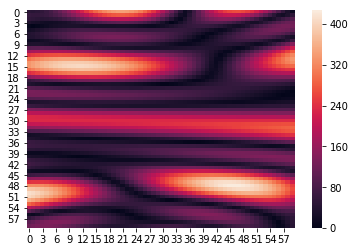

In [14]:
import seaborn as sns
sig_mean = np.mean(sig_mat,axis=0)
ax = sns.heatmap(sig_mat[50,:2*th_range,:2*si_range])#,vmin=np.median(sig_mat))


In [15]:
target_id

array([17,  1,  2, 11])

In [17]:
# make data generator
def gen_csi(df_info,dict_avg,id_num,len_num):
    for file in np.unique(df_info.id.values):
        
        # Label
        id_key = df_info[df_info.id==file][['id_person','id_location','id_direction','id_exp']].values[0].astype('int')
        data1_y = dict_id[id_key[0]]
        
        # read sample data
        # load and uncompress.
        with gzip.open(path_csi+file+'.pickle.gz','rb') as f:
            data1 = pickle.load(f)
            
        # subtract avg
        read_avg = dict_avg[id_key[0]][0]
        nonzero_avg = read_avg[np.nonzero(read_avg)].reshape([-1,30,2,3])
        arr_avg = np.mean(nonzero_avg,axis=0)
        data1_diff = data1 - arr_avg #np.diff(data1,axis=0)

        s_idx = (np.arange(len_num) * data1_diff.shape[0] / len_num).astype('int')
        data1_s = data1_diff[s_idx]
        # zero pad
        #pad_len = len_num - data1_diff.shape[0]
        #data1_pad = np.pad(data1_diff,((0,pad_len),(0,0),(0,0),(0,0)),'constant',constant_values=0)

        # subcarrier info
        #data1_sc_df = pd.read_csv(path_sc + file + '_df_sc.csv')
        #data1_time = np.diff(data1_sc_df['timestamp_low'])
        #data1_time_pad = np.pad(data1_time,((1,pad_len)),'constant',constant_values=0)
        
        
        yield(data1_s ,data1_y,id_key,file)#,data1_time_pad)


gen = gen_csi(df_info,dict_avg,no_classes,csi_time)
target_sig,target_lab,target_id,target_file = next(gen)

In [18]:
target_file

'S017_1_2_11'

In [21]:
len(df_info.id.unique())

3632

In [23]:
df_info.id_person.unique()

array([ 17,  18,  19,  22,  24,  25,  26,  27,  28,  29,  30,  31,  32,
        33,  34,  35,  36,  37,  39,  40,  41,  42,  43,  44,  45,  46,
        47,  48,  49,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,
        60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72,
        73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,  85,
        86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,
        99, 100, 101, 102, 103, 104, 105, 106, 107], dtype=int64)

In [24]:
df_info = df_info[df_info.id_location==1]

In [25]:
len(df_info.id.unique())

3632

In [26]:
df_info.iloc[0:100]

,id,len,mean,std,id_person,id_location,id_direction,id_exp,id_paper,file,name,id_sign,median,max
0,S017_1_2_11,10258.0,22.066244,5.465441,17,1,2,11,IMG_0721,IMG_0721_10.png,강경휘,17,22.592283,46.589730
1,S017_1_2_11,10258.0,22.066244,5.465441,17,1,2,11,IMG_0721,IMG_0721_2.png,강경휘,17,22.592283,46.589730
2,S017_1_2_11,10258.0,22.066244,5.465441,17,1,2,11,IMG_0721,IMG_0721_3.png,강경휘,17,22.592283,46.589730
3,S017_1_2_11,10258.0,22.066244,5.465441,17,1,2,11,IMG_0721,IMG_0721_4.png,강경휘,17,22.592283,46.589730
4,S017_1_2_11,10258.0,22.066244,5.465441,17,1,2,11,IMG_0721,IMG_0721_5.png,강경휘,17,22.592283,46.589730
5,S017_1_2_11,10258.0,22.066244,5.465441,17,1,2,11,IMG_0721,IMG_0721_7.png,강경휘,17,22.592283,46.589730
6,S017_1_2_11,10258.0,22.066244,5.465441,17,1,2,11,IMG_0721,IMG_0721_8.png,강경휘,17,22.592283,46.589730
7,S017_1_2_11,10258.0,22.066244,5.465441,17,1,2,11,IMG_0721,IMG_0721_9.png,강경휘,17,22.592283,46.589730
8,S017_1_2_12,10215.0,21.874904,5.404869,17,1,2,12,IMG_0721,IMG_0721_10.png,강경휘,17,22.460603,43.945403
9,S017_1_2_12,10215.0,21.874904,5.404869,17,1,2,12,IMG_0721,IMG_0721_2.png,강경휘,17,22.460603,43.945403


In [28]:
person_uid

array([ 17,  18,  19,  22,  24,  25,  26,  27,  28,  29,  30,  31,  32,
        33,  34,  35,  36,  37,  39,  40,  41,  42,  43,  44,  45,  46,
        47,  48,  49,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,
        60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72,
        73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,  85,
        86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,
        99, 100, 101, 102, 103, 104, 105, 106, 107], dtype=int64)

In [29]:
np.unique(df_info.id.values)

array(['S017_1_2_11', 'S017_1_2_12', 'S017_1_2_2', ..., 'S107_1_4_7',
       'S107_1_4_8', 'S107_1_4_9'], dtype=object)

In [31]:
ufile = np.unique(df_info.id.values)

In [36]:
f = ufile[0]

In [37]:
np.save(path_mit_image + f + '.npy',sig_mat)

In [38]:
aa = np.load(path_mit_image+f+'.npy')

In [39]:
aa.shape

(100, 60, 60)